Exploratory data analysis for the Myers-Briggs Twitter project.

All tweets collected from Twitter.

In [1]:
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

TYPE = 'Type'
LOGISTIC = 'logistic'
NAIVE_BAYES = 'multinomial naive Bayes'

# Get all the tweets.
path = r'D:\Springboard_DataSci\Twitter_MBTI_predictor\Data Output'
os.chdir(path)

In [2]:
letters = [['E', 'I'], ['S', 'N'], ['F', 'T'], ['J', 'P']]
MB_types = []
# Get the list of types using binary math.
for i in range(16):
    MB_types.append(letters[0][i//8%2] + letters[1][i//4%2]
                      + letters[2][i//2%2] + letters[3][i%2])

In [3]:
def load_tweets(MB_type):
    return pd.read_csv(
        path + '\\' + MB_type + '_tweets.csv', parse_dates=[2],
        infer_datetime_format=True)

In [4]:
# Load tweets
print('Loading tweets:', end=' ')
for i, MB_type in enumerate(MB_types):
    print(f'{MB_type}', end=' ')
    if i == 0:
        tweets = load_tweets(MB_type)
    else:
        tweets = tweets.append(load_tweets(MB_type))

Loading tweets: ESFJ ESFP ESTJ ESTP ENFJ ENFP ENTJ ENTP ISFJ ISFP ISTJ ISTP INFJ INFP INTJ INTP 

In [5]:
# Classify their type
for i, letter in enumerate('ESFJ'):
    tweets[letter] = tweets['MBTI'].str[i] == letter

In [6]:
def analyze_tweets(tweets, letter, classifier, min_df=200, max_df=1.,
                   alpha=1., C=1, stop_words=None, get_words_and_probas=False):
    '''Text classification of the tweets'''
    y = tweets[letter]
    vectorizer = CountVectorizer(min_df=min_df, max_df=max_df,
                                 stop_words=stop_words)
    tweets = tweets['Tweet'].to_list()
    # Get the sparse matrix (x, y) of (tweetID, wordID).
    X = vectorizer.fit_transform(tweets)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=0)
    if classifier==LOGISTIC:
        clf = LogisticRegression(C=C, max_iter=1e3, random_state=0)\
            .fit(X_train, y_train)
    if classifier==NAIVE_BAYES:
        clf = MultinomialNB(alpha=alpha).fit(X_train, y_train)
    if get_words_and_probas:
        x = np.eye(X_test.shape[1])
        words_all = np.array(vectorizer.get_feature_names())
        probs = clf.predict_log_proba(x)[:, 0]
    else:
        words_all = probs = None
    return clf.score(X_train, y_train), clf.score(X_test, y_test), words_all,\
        probs
        
def sort_words_by_coef(words, coefs):
    words_order = np.argsort(coefs)
    return words[words_order], coefs[words_order]

In [7]:
print('\nAnalyzing tweets with logistic regression')
for min_df in [10, 25, 50, 100, 250, 500]:
    score_base = analyze_tweets(tweets, 'E', classifier=LOGISTIC,
                                min_df=min_df)
    print(f'Full set, min_df={min_df} training and test scores:', end=' ')
    print(round(score_base[0], 4), round(score_base[1], 4))


Analyzing tweets with logistic regression
Full set, min_df=10 training and test scores: 0.7019 0.6188
Full set, min_df=25 training and test scores: 0.6436 0.5872
Full set, min_df=50 training and test scores: 0.6123 0.5701
Full set, min_df=100 training and test scores: 0.5874 0.5574
Full set, min_df=250 training and test scores: 0.5641 0.5509
Full set, min_df=500 training and test scores: 0.5501 0.5441


Lower min_dfs give better fits but also cause overfitting. Let's retry with
multinomial naive Bayes and see what kinds of results we get. We also remove
common "stop" words.

In [8]:
print('\nAnalyzing tweets with naive Bayes and stop words removed')
for min_df in [10, 25, 50, 100, 250, 500]:
    score_base = analyze_tweets(tweets, 'E', classifier=NAIVE_BAYES,
                                min_df=min_df, stop_words=ENGLISH_STOP_WORDS)
    print(f'No stop words, min_df={min_df} training and test scores:', end=' ')
    print(round(score_base[0], 4), round(score_base[1], 4))


Analyzing tweets with naive Bayes and stop words removed
No stop words, min_df=10 training and test scores: 0.6734 0.618
No stop words, min_df=25 training and test scores: 0.6233 0.5856
No stop words, min_df=50 training and test scores: 0.594 0.5668
No stop words, min_df=100 training and test scores: 0.5733 0.5557
No stop words, min_df=250 training and test scores: 0.5528 0.5473
No stop words, min_df=500 training and test scores: 0.5396 0.5359


Scores are marginally hurt, but we have fewer features to worry about.
This is an acceptable trade. Let's see what the features are.

In [9]:
min_df=10
print(f'\nNaive Bayes, stop words removed, min_df={min_df}')
bayes_results = analyze_tweets(
    tweets, 'E', classifier=NAIVE_BAYES, min_df=min_df,
    stop_words=ENGLISH_STOP_WORDS, get_words_and_probas=True)
print('Scores:', round(bayes_results[0], 4), round(bayes_results[1], 4))
nb_words = bayes_results[2]
nb_coefs = bayes_results[3]
nb_words, nb_coefs = sort_words_by_coef(nb_words, nb_coefs)


Naive Bayes, stop words removed, min_df=10
Scores: 0.6734 0.618


A lot of these word are nonsense, probably other users. We need to rerun
this with a much higher min_df, even at the cost of scores. Let's also lower
the value of alpha in the naive Bayes to get stronger regularization.

In [10]:
min_df=200; alpha=5
print(f'\nNaive Bayes, stop words removed, min_df={min_df}, alpha={alpha}')
bayes_results = analyze_tweets(
    tweets, 'E', classifier=NAIVE_BAYES, min_df=min_df, alpha=alpha,
    stop_words=ENGLISH_STOP_WORDS, get_words_and_probas=True)
print('Scores:', round(bayes_results[0], 4), round(bayes_results[1], 4))
nb_words = bayes_results[2]
nb_coefs = bayes_results[3]
nb_words, nb_coefs = sort_words_by_coef(nb_words, nb_coefs)


Naive Bayes, stop words removed, min_df=200, alpha=5
Scores: 0.5567 0.549


Perhaps returning the stop words and lowering min_df will help.

In [11]:
min_df=100; alpha=5
print(f'\nNaive Bayes, stop words returned, min_df={min_df}, alpha={alpha}')
bayes_results = analyze_tweets(
    tweets, 'E', classifier=NAIVE_BAYES, min_df=min_df, alpha=alpha,
    get_words_and_probas=True)
print('Scores:', round(bayes_results[0], 4), round(bayes_results[1], 4))
nb_words = bayes_results[2]
nb_coefs = bayes_results[3]
nb_words, nb_coefs = sort_words_by_coef(nb_words, nb_coefs)


Naive Bayes, stop words returned, min_df=100, alpha=5
Scores: 0.576 0.5612


These results leave a lot to be desired. One possibility is that when one
author tweets a lot of words, they unduly weight particular words in their
favor. Let's combine tweets per author.

In [12]:
tweets_per_author = tweets.copy()
tweets_per_author['Tweet'] = tweets_per_author['Tweet']\
    .apply(lambda x: x + ' ')
tweets_per_author = tweets_per_author.groupby(
    tweets_per_author['Screen name'])['Tweet'].apply(lambda x: x.sum())\
    .reset_index()
# This threw away the MBTI info, but we can get it back.
authors_MBTI = tweets[['Screen name', 'E', 'S', 'F', 'J']].drop_duplicates()
tweets_per_author = tweets_per_author.merge(
    authors_MBTI, 'left', on='Screen name')

Let's rerun with combined tweets. We try a lower min_df because of the
combined words.

In [13]:
min_df=50
print(f'\nNaive Bayes, min_df={min_df}')
bayes_results = analyze_tweets(
    tweets_per_author, 'E', classifier=NAIVE_BAYES, min_df=min_df,
    get_words_and_probas=True)
print('Scores:', round(bayes_results[0], 4), round(bayes_results[1], 4))
nb_words = bayes_results[2]
nb_coefs = bayes_results[3]
nb_words, nb_coefs = sort_words_by_coef(nb_words, nb_coefs)


Naive Bayes, min_df=50
Scores: 0.7883 0.595


Badly overfit. Let's change min_df.

In [14]:
min_df=200
print(f'\nNaive Bayes, stop words removed, min_df={min_df}')
bayes_results = analyze_tweets(
    tweets_per_author, 'E', classifier=NAIVE_BAYES, min_df=min_df,
    get_words_and_probas=True)
print('Scores:', round(bayes_results[0], 4), round(bayes_results[1], 4))
nb_words = bayes_results[2]
nb_coefs = bayes_results[3]
nb_words, nb_coefs = sort_words_by_coef(nb_words, nb_coefs)


Naive Bayes, stop words removed, min_df=200
Scores: 0.7167 0.595


Less bad but still problematic. Let's experiment with alpha.

In [15]:
min_df=200; alpha=10
print(f'\nNaive Bayes, min_df={min_df}, alpha={alpha}')
bayes_results = analyze_tweets(
    tweets_per_author, 'E', classifier=NAIVE_BAYES, min_df=min_df, alpha=alpha,
    get_words_and_probas=True)
print('Scores:', round(bayes_results[0], 4), round(bayes_results[1], 4))
nb_words = bayes_results[2]
nb_coefs = bayes_results[3]
nb_words, nb_coefs = sort_words_by_coef(nb_words, nb_coefs)


Naive Bayes, min_df=200, alpha=10
Scores: 0.7183 0.6


In [16]:
min_df=200; alpha=0.1
print(f'\nNaive Bayes, min_df={min_df}, alpha={alpha}')
bayes_results = analyze_tweets(
    tweets_per_author, 'E', classifier=NAIVE_BAYES, min_df=min_df, alpha=alpha,
    get_words_and_probas=True)
print('Scores:', round(bayes_results[0], 4), round(bayes_results[1], 4))
nb_words = bayes_results[2]
nb_coefs = bayes_results[3]
nb_words, nb_coefs = sort_words_by_coef(nb_words, nb_coefs)


Naive Bayes, min_df=200, alpha=0.1
Scores: 0.7158 0.595


Perhaps min_df is an issue?

In [17]:
min_df=500
print(f'\nNaive Bayes, min_df={min_df}')
bayes_results = analyze_tweets(
    tweets_per_author, 'E', classifier=NAIVE_BAYES, min_df=min_df,
    get_words_and_probas=True)
print('Scores:', round(bayes_results[0], 4), round(bayes_results[1], 4))
nb_words = bayes_results[2]
nb_coefs = bayes_results[3]
nb_words, nb_coefs = sort_words_by_coef(nb_words, nb_coefs)


Naive Bayes, min_df=500
Scores: 0.66 0.5975


In [18]:
min_df=250
print(f'\nNaive Bayes, min_df={min_df}')
bayes_results = analyze_tweets(
    tweets_per_author, 'S', classifier=NAIVE_BAYES, min_df=min_df,
    get_words_and_probas=True)
print('Scores:', round(bayes_results[0], 4), round(bayes_results[1], 4))
nb_words = bayes_results[2]
nb_coefs = bayes_results[3]
nb_words, nb_coefs = sort_words_by_coef(nb_words, nb_coefs)


Naive Bayes, min_df=250
Scores: 0.6542 0.675


In [19]:
def get_word_use(words, tweets_with_words, trait, other_trait):
    '''Split totals of unique authors who tweeted these words.
    Trait needs to be E/S/F/J; other_trait, I/N/T/P.'''
    unique_words = pd.DataFrame(columns=['Word', trait, other_trait])
    for i, word in enumerate(words):
        # Column 1: Whether each author tweeted the word of interest.
        word_in_tweets = tweets_with_words['Tweet'].str.contains(word)\
            .to_frame()
        # Column 2: Whether that author has the trait.
        word_in_tweets[trait] = tweets_with_words[trait].to_numpy()
        # Now get the summaries. Set the index to the trait boolean
        word_use = word_in_tweets.value_counts().reset_index()\
            .set_index(trait)
        # Only keep the ones with the word actually in them
        word_use = word_use[word_use['Tweet']]
        # Add this info to unique_words
        unique_words.loc[i] = [word, word_use.loc[True, 0],
                               word_use.loc[False, 0]]
    # Column 1 is the trait; column 2 is the "not trait."
    unique_words['Percent ' + trait] = 100*unique_words[trait] /\
        (unique_words[trait]+unique_words[other_trait])
    unique_words.sort_values('Percent ' + trait, inplace=True)
    return unique_words

In [20]:
print('Calculating unique words')
unique_words_EI = get_word_use(nb_words, tweets_per_author, trait='E',
                               other_trait='I')
print(unique_words_EI)

Calculating unique words
          Word    E    I Percent E
680     anyway  136  189   41.8462
218   probably  228  311   42.3006
26        lmao   92  123   42.7907
490  character  176  226   43.7811
756    writing  133  169   44.0397
..         ...  ...  ...       ...
125      girls  150  113   57.0342
82     service  210  158   57.0652
736      local  164  116   58.5714
45      coffee  173  119   59.2466
621    sharing  175  117   59.9315

[760 rows x 4 columns]


In [21]:
unique_words_SN = get_word_use(nb_words, tweets_per_author, trait='S',
                               other_trait='N')
print(unique_words_SN)

          Word    S    N Percent S
755      truth  114  175   39.4464
746  important  174  266   39.5455
757      trump   39   59   39.7959
735    history  107  158   40.3774
742   children  103  148   41.0359
..         ...  ...  ...       ...
176     friday   28   20   58.3333
11       kinda  178  122   59.3333
26        lmao  131   84   60.9302
29         wtf  102   61   62.5767
7          idk  139   81   63.1818

[760 rows x 4 columns]


In [22]:
unique_words_FT = get_word_use(nb_words, tweets_per_author, trait='F',
                               other_trait='T')
print(unique_words_FT)

          Word    F    T Percent F
754   american   18   32        36
176     friday   19   29   39.5833
87       level  155  220   41.3333
533     office  146  204   41.7143
643  attention  109  149   42.2481
..         ...  ...  ...       ...
638  wonderful  149  104   58.8933
8         baby  264  180   59.4595
29         wtf   98   65   60.1227
197      sweet  267  173   60.6818
131        omg  161   95   62.8906

[760 rows x 4 columns]


In [23]:
unique_words_JP = get_word_use(nb_words, tweets_per_author, trait='J',
                               other_trait='P')
print(unique_words_JP)

        Word    J    P Percent J
7        idk   66  154        30
176   friday   16   32   33.3333
26      lmao   72  143   33.4884
569  youtube   20   39   33.8983
29       wtf   57  106   34.9693
..       ...  ...  ...       ...
660   system  193  140    57.958
87     level  220  155   58.6667
736    local  165  115   58.9286
679    books  178  122   59.3333
621  sharing  178  114   60.9589

[760 rows x 4 columns]


In [24]:
def plot_top_words(unique_words, letters):
    # Get the first 10 and last 10 words on the axis
    m_top = 10
    n = unique_words.shape[0]
    word_slice = np.r_[0:m_top, n-m_top:n]
    to_plot = unique_words.iloc[word_slice]
    x = np.arange(to_plot.shape[0]+1)
    y = to_plot.iloc[:,-1].to_numpy()-50
    y = np.insert(y, m_top, 0)
    word_slice = np.insert(word_slice, m_top, m_top)
    words_top_bottom = unique_words.iloc[word_slice]['Word']\
        .drop(index=unique_words.index[m_top])
    
    # Plot them
    fig, ax = plt.subplots()
    ax.bar(x[y<0], y[y<0], color='r')
    ax.bar(x[y>0], y[y>0], color='b')
    ax.axhline(c='k')
    ax.set_xticks(np.delete(x, m_top))
    ax.set_xticklabels(words_top_bottom, rotation=60)
    ax.set_xlabel(f'← {letters[1]} Words {letters[0]} →', fontsize=20)
    ax.set_ylabel('Percent Above/Below 50%', fontsize=16)
    ax.set_ylim([-25,25])
    ax.tick_params(right=True, labelright=True) #for easier reading
    plt.tight_layout()

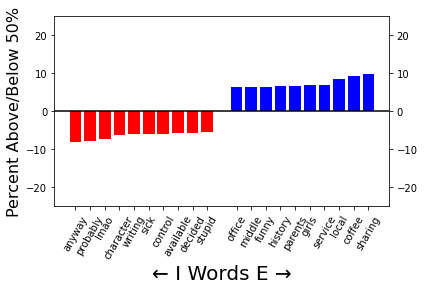

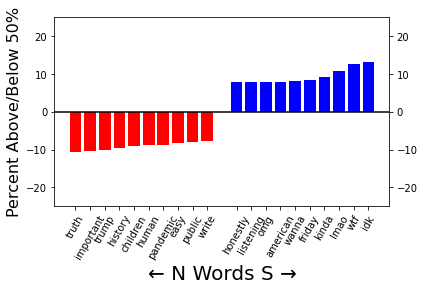

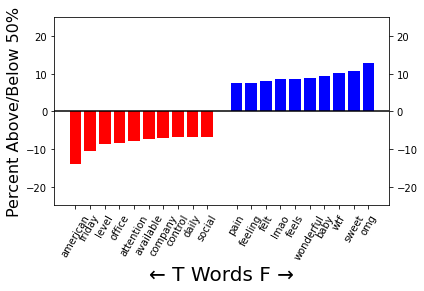

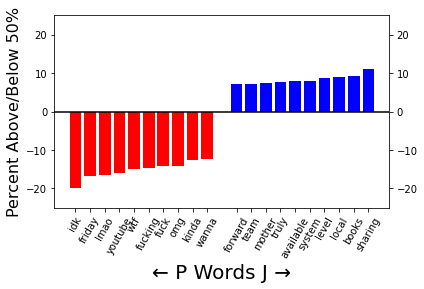

In [25]:
for i in range(4):
    unique_words = [unique_words_EI, unique_words_SN,
                    unique_words_FT, unique_words_JP][i]
    plot_top_words(unique_words, letters[i])

Some percentages farther away from 50 start to show up. Perhaps we should
lower min_df after all?

Let's look for tweets that contain a particular word. We include the ability to filter by letter.

In [26]:
def tweets_that_contain(tweets, word, MB_letter=None):
    tweets = tweets[tweets['Tweet'].str.contains(word)]
    if MB_letter is not None:
        if MB_letter == 'I':
            tweets = tweets[~tweets['E']]
        elif MB_letter == 'E':
            tweets = tweets[tweets['E']]
        elif MB_letter == 'N':
            tweets = tweets[~tweets['S']]
        elif MB_letter == 'S':
            tweets = tweets[tweets['S']]
        elif MB_letter == 'T':
            tweets = tweets[~tweets['F']]
        elif MB_letter == 'F':
            tweets = tweets[tweets['F']]
        elif MB_letter == 'P':
            tweets = tweets[~tweets['J']]
        elif MB_letter == 'J':
            tweets = tweets[tweets['J']]
        else:
            raise ValueError('Must select a Myers-Briggs letter')
    return tweets[['Screen name', 'Time', 'Tweet']]

In [27]:
specific_tweets_stupid = tweets_that_contain(tweets, 'stupid', 'I')
print(specific_tweets_stupid[:5])

specific_tweets_lmao = tweets_that_contain(tweets, 'lmao', 'S')
print(specific_tweets_lmao[:5])

specific_tweets_baby = tweets_that_contain(tweets, 'baby', 'F')
print(specific_tweets_baby[:5])

specific_tweets_idk = tweets_that_contain(tweets, 'idk', 'P')
print(specific_tweets_idk[:5])

          Screen name                Time  \
40    oregon_resister 2021-05-18 22:33:56   
92    oregon_resister 2021-05-14 00:31:52   
128   GodineedYoualw0 2019-11-28 07:01:06   
510    PinkGlitterFox 2021-05-19 10:31:04   
1619         binnierv 2021-05-22 22:10:27   

                                                  Tweet  
40              @JLVsTW1 Delusional and stupid besides.  
92    @kathrynresister Play stupid games, win stupid...  
128   writing it down as rant i guess but it's stupi...  
510   Stupid agoraphobia 😒 been trying to get out to...  
1619  The fact that Finland and Italy are not in the...  
         Screen name                Time  \
1888  PrincessRwanda 2020-09-05 19:49:29   
1916  PrincessRwanda 2020-09-05 18:24:50   
1930  PrincessRwanda 2020-07-30 08:23:21   
2387       tuneycorn 2021-05-21 05:46:48   
4143          joysuo 2021-04-08 22:42:54   

                                                  Tweet  
1888  We continued our journey until we got to the c...  
